In [1]:
try:
    import plaidml.keras
    plaidml.keras.install_backend()
    import os
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
except:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras import backend as K
# example of training a gan on mnist
import keras
from keras.optimizers import Adam
from keras import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#------------------------------
print("Running on MAC OS")


import os
from os.path import exists as file_exists    

# Libraries
import glob
import csv
import json
import math
import joblib
#------------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import visualkeras

# Metric
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
#------------------------------

import scipy
import scipy.cluster.hierarchy as sch

# %%
# Creating two lists of ambient and attack datasets
cur_dir= os.getcwd()
dataset = 'syncan'


ambient_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//ambients//*.csv")
attack_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//attacks//*.csv")

# Creating two lists of file names 
ambient_files = [x.split("/")[-1].split(".")[0][0:-10] for x in ambient_dirs]
attack_files = [x.split("/")[-1].split(".")[0][0:-10] for x in attack_dirs]

print(f"Ambient files are:\n {ambient_files[0:]}, etc.")
print(f"Attack files are:\n {attack_files[0:]}, etc.")

# %%
ambient_files

# %%
# Defining parameters...........

Running on MAC OS
Ambient files are:
 ['train_2', 'train_1', 'train_3', 'train_4'], etc.
Attack files are:
 ['test_suppress', 'test_flooding', 'test_playback', 'test_continuous', 'test_plateau'], etc.


['train_2', 'train_1', 'train_3', 'train_4']

In [2]:
ambient_files

['train_2', 'train_1', 'train_3', 'train_4']

In [3]:
def find_attacks(y_list):

    attack_index = []
    attacks = []
    y_1 = 0
    y_2 = 0

    #attacks = []
    for i, y in enumerate (y_list):
        y_2 = y
        if y_1 == 0 and y_2 == 1:
            starting = i
            #print("Starting: ", starting)
        elif y_1 == 1 and y_2 == 0:
            ending = i
            attacks.append([starting, ending, (ending-starting)])
            attack_index += list(range(starting,ending, 1))
            #print(starting, ending, ending-starting)
        y_1 = y_2

#     print("Total attacks", len(attacks))
#     print("Attack positions (starting, ending, ending-starting)\n", attacks[0:2])
    
    return attacks, attack_index


In [4]:
# %%
# Defining functions..............................
#-----------------------------------------------
def sigmoid(x):
    return 1/(1+np.exp(-x))
#-----------------------------------------------
def create_x_sequences(X_values, time_step, window_step, sampling_period):
    X_output = []
    x_indeces = []
    for i in range(100*time_step, len(X_values), window_step):
        X_output.append(X_values[(i - sampling_period*time_step) : i : sampling_period])
        x_indeces.append(i)
    return np.array(x_indeces), np.stack(X_output).reshape(-1, time_step, noOfSignals, 1)

#-----------------------------------------------
def create_y_sequences(y_values, time_step, window_step, sampling_period):
    y_output = []
    for i in range(100*time_step, len(y_values), window_step):
        if y_values[(i - sampling_period*time_step) : i].sum() > 0:
            y_output.append(1)
        else:
            y_output.append(0)
    return np.stack(y_output)

#--------------- Create Folders -------------
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Detectory created!\n{directory}")
        return False
    else:
        return True
#--------------------------------------

#--------------- Create Folders -------------
def get_minmax_scaler(columns):
    df_min_max = pd.read_csv(f"Scalling_Data/min_max_values_{dataset}.csv", index_col=0)[columns]
    scaler = MinMaxScaler()
    scaler.fit(df_min_max.values)
    print("scaler loaded...!")
    return scaler
#--------------------------------------
#--------------------------------------
def calc_loss(x_org, autoencoder):
    x_recon = autoencoder.predict(x_org)
    recon_loss = np.abs(x_org - x_recon)
    return recon_loss #sigmoid(np.mean(np.mean(recon_loss, axis = 1), axis = 1))


In [5]:
folder_to_check = ["label", "prediction", "results", "thresholds"]
for folder in folder_to_check:
    ensure_dir(f"data/{folder}/{dataset}/")

In [6]:
if dataset == 'syncan':
    signals_in_cluster = ['Sig_1_of_ID_2',
        'Sig_1_of_ID_7',
        'Sig_2_of_ID_3',
        'Sig_1_of_ID_10',
        'Sig_1_of_ID_9',
        'Sig_1_of_ID_1',
        'Sig_4_of_ID_10',
        'Sig_2_of_ID_2',
        'Sig_3_of_ID_10',
        'Sig_1_of_ID_6',
        'Sig_2_of_ID_5',
        'Sig_1_of_ID_4',
        'Sig_1_of_ID_5',
        'Sig_3_of_ID_2',
        'Sig_1_of_ID_8',
        'Sig_2_of_ID_6',
        'Sig_2_of_ID_10',
        'Sig_2_of_ID_7',
        'Sig_2_of_ID_1',
        'Sig_1_of_ID_3']
    
    
# Selected signals...........
noOfSignals = len(signals_in_cluster)
print("noOfSignals: ", noOfSignals)

signals_in_cluster

noOfSignals:  20


['Sig_1_of_ID_2',
 'Sig_1_of_ID_7',
 'Sig_2_of_ID_3',
 'Sig_1_of_ID_10',
 'Sig_1_of_ID_9',
 'Sig_1_of_ID_1',
 'Sig_4_of_ID_10',
 'Sig_2_of_ID_2',
 'Sig_3_of_ID_10',
 'Sig_1_of_ID_6',
 'Sig_2_of_ID_5',
 'Sig_1_of_ID_4',
 'Sig_1_of_ID_5',
 'Sig_3_of_ID_2',
 'Sig_1_of_ID_8',
 'Sig_2_of_ID_6',
 'Sig_2_of_ID_10',
 'Sig_2_of_ID_7',
 'Sig_2_of_ID_1',
 'Sig_1_of_ID_3']

In [7]:
# #-----------------------
# # time_steps = [20, 50, 100]
time_steps = [50]

window_step = 1


if dataset == "syncan":
    sampling_periods = [1, 5, 10, 20, 50]
    loss_factors = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5, 99.99]
    time_factors = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5, 99.99]
    signal_factors = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5, 99.99]


version = 'v5'

In [8]:
# #-----------------------
transfer = True

# %%
#------------------------------
training_files = ambient_files
training_dirs = ambient_dirs


testing_files = attack_files
testing_dirs = attack_dirs

#-----------------------
ensure_dir(f"plots//{dataset}//")
ensure_dir("AE_Models//")
ensure_dir("Scalling_Data//")
ensure_dir("plots//Overall//")


True

In [9]:
class node:
    def __init__(self, th_name, th_exist, th_data, child_list):
        self.th_name = th_name
        self.th_exist = th_exist
        self.th_data = th_data
        self.child_list = child_list    

In [10]:
loss_missing = []
time_missing = []
signal_missing = []

loss_dict = {}

for time_step in time_steps:
    for sampling_period in sampling_periods:
               
            loss_th = f'thresholds_loss_{time_step}_{sampling_period}'
            loss_th_dir = f'data/thresholds/{dataset}/{loss_th}'
            
            try:
                loss_th_data = pd.read_csv(loss_th_dir+".csv")
                loss_th_exist = True 
            except:
                loss_th_data = None
                loss_th_exist = False

            loss_node = node(loss_th, loss_th_exist, loss_th_data, {})
            loss_dict[loss_th] = loss_node
            
            for loss_factor in loss_factors:
                
                time_th = f'thresholds_time_{time_step}_{sampling_period}_{loss_factor}'
                time_th_dir = f'data/thresholds/{dataset}/{time_th}'
                try:
                    time_th_data = pd.read_csv(time_th_dir+".csv")
                    time_th_exist = True 
                except:
                    time_th_data = None
                    time_th_exist = False

                time_node = node(time_th, time_th_exist, time_th_data, {})
                loss_node.child_list[time_th] = time_node

                for time_factor in time_factors:
                    # for signal_factor in signal_factors:
                    signal_th = f'thresholds_signal_{time_step}_{sampling_period}_{loss_factor}_{time_factor}'
                    signal_th_dir = f'data/thresholds/{dataset}/{signal_th}'

                    try:
                        signal_th_data = pd.read_csv(signal_th_dir+".csv")
                        signal_th_exist = True 
                    except:
                        signal_th_data = None
                        signal_th_exist = False
                        print("Node: ", signal_th)
                    signal_node = node(signal_th, signal_th_exist, signal_th_data, {})
                    time_node.child_list[signal_th] = signal_node

In [11]:
# time_node.th_data

In [12]:

def generate_and_save_prediction_loss(node, y_train_prob_org_dict):
    #do something
    args = node.th_name.split("_")
    th_type = args[1]
    time_step = int(args[2])
    sampling_period = int(args[3])
    # loss_factor = float(args[4])
    # th_loss_df = pd.DataFrame([])

    print(node.th_name)
    for file_index, (file_name, file_dir) in enumerate(zip(ambient_files[:], ambient_dirs[:])):
         
        try: 
            y_train_prob_org_dict[f"{file_name}_{time_step}_{sampling_period}"]
            print(f"{file_name}_{time_step}_{sampling_period} exists.....")
        except:
            print("Loading dataset: ",file_name)

            if file_name == 'ambient_highway_street_driving_long':
                continue
            # Checking if the signalwise data already exists
            sig_df = pd.read_csv(file_dir, index_col = 0) 
            print(f"{file_name} onboarded!")

            # Defining the number of signals..............................
            training_samples = 1
            num_of_train_samples = int(sig_df.shape[0]*training_samples)
            sig_df = sig_df.iloc[0:num_of_train_samples].copy()        
            y_train = sig_df['Label'].iloc[0:num_of_train_samples].copy()
            sig_df = sig_df[signals_in_cluster].copy()


            if dataset == 'road':
                # Forward filling algorithm...........
                print("Forward filling...")
                sig_df = sig_df.ffill().copy()
                sig_df = sig_df.bfill().dropna()   
                #------------------------------------
            else:
                print("No treatment needed for SynCAN!")

            X_train = sig_df.values.copy()
            #--------------------------------
            print("X_train.shape", X_train.shape)

            scaler_train = get_minmax_scaler(signals_in_cluster)
            X_train = scaler_train.transform(X_train).copy()
            print("Done data treatment..")



            #find losses.............................
            print("Creating sequences....")
            x_train_index, x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period)
            y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

            print("Training input shape: ", x_train_seq.shape)

            #.......................... Training the model ....................
            print("------------- Starting the training process----------------")
    #         try:
    # #                     checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"
    #             checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_xxx_{version}_{dataset}_{time_step}_1_{sampling_period}_{transfer}.h5"
    #             autoencoder = load_model(checkpoint_path)
    #             print(f"{dataset}, Loaded...{checkpoint_path}")
    #         except:
    #             #checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"                  
    #             #checkpoint_path = f"AE_Models//{dataset}_old//Autoencoder_Final_{time_step}_1_{sampling_period}_True.h5"

            if dataset =='syncan':
                checkpoint_path = f"AE_Models//{dataset}_old//Autoencoder_Final_{time_step}_1_{sampling_period}_True.h5"
            elif dataset =='road':
                checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"


            autoencoder = load_model(checkpoint_path)
            print(f"{dataset}, Loaded...{checkpoint_path}")

            print("------------------------ Done ------------------------")

            print("Predicting..losses...")
            #-------------  Training ------------------
            y_train_prob_org = calc_loss(x_train_seq[0::], autoencoder)[:,:,:,0]
            #-------------------------------------------
            y_train_prob_org_dict[f"{file_name}_{time_step}_{sampling_period}"] = y_train_prob_org.copy()
 

In [13]:
y_train_prob_org_dict = {}

In [14]:
def generate_and_save_loss_data(node, y_train_prob_org_dict, loss_factors):

    print("Starting : generate_and_save_loss_data")
    #do something
    args = node.th_name.split("_")
    th_type = args[1]
    time_step = int(args[2])
    sampling_period = int(args[3])

    th_loss_df = pd.DataFrame([])

    print(node.th_name)
    for file_index, (file_name, file_dir) in enumerate(zip(ambient_files[:], ambient_dirs[:])):

        try:
            y_train_prob_org = y_train_prob_org_dict[f"{file_name}_{time_step}_{sampling_period}"].copy()
            y_train_prob = y_train_prob_org.reshape(-1,noOfSignals)
        except:
            print("Prediction data does not exist!!!")
    

        print(".....loss_factors.....")
        #print("Loss:", loss_factor)
        th_values = {}
        for Signal, y_train_prob_signal in enumerate(y_train_prob.T):

            for loss_factor in loss_factors:
                th = np.percentile(y_train_prob_signal, loss_factor)
                th_values['file'] = file_name
                th_values['sampling_period'] = sampling_period
                th_values['time_step'] = time_step
                th_values['loss_factor'] = loss_factor
                th_values['th'] = th 
                th_values['Signal'] = Signal
                # ths[f"{file_name}_{time_step}_{sampling_period}_{factor}_{Signal}"] = th
                th_loss_df = pd.concat([th_loss_df, pd.DataFrame(th_values, index = [0])], ignore_index= True)
        #-------------------------------------------------------------------------------------------
    ths_loss = th_loss_df.groupby(['time_step', 'sampling_period', 'loss_factor', 'Signal']).mean().reset_index()
    ths_loss.to_csv(f'data/thresholds/{dataset}/{node.th_name}.csv', index = True, header = True)
    print(f'data/thresholds/{dataset}/{node.th_name}.csv --- Saved!!!')
    node.th_data = ths_loss
    node.th_exist = True
    return node

def generate_and_save_time_data(node, loss_df, y_train_prob_org_dict, time_factors):

    print("Starting : generate_and_save_loss_data")
    #do something
    args = node.th_name.split("_")
    th_type = args[1]
    time_step = int(args[2])
    sampling_period = int(args[3])
    loss_factor = float(args[4])

    th_time_df = pd.DataFrame([])

    print(node.th_name)
    for file_index, (file_name, file_dir) in enumerate(zip(ambient_files[:], ambient_dirs[:])):

        try:
            y_train_prob_org = y_train_prob_org_dict[f"{file_name}_{time_step}_{sampling_period}"].copy()
        except:
            print("Prediction data does not exist!!!")
    
        print(".....time_factors.....")

        # Starting with time steps violations.............
        # ths_image = []
        # for signal in range(noOfSignals):
        #     ths_image.append(ths_loss.loc[(time_step, sampling_period, loss_factor, signal)]['th'])
        # ths_image = np.array(ths_image)

        # ths_loss_image = loss_df['th'].values

        # ths_loss_image = np.squeeze(loss_df.loc[(loss_df.index.get_level_values('loss_factor') == loss_factor)].values)
        ths_loss_image = np.squeeze(loss_df[loss_df['loss_factor'] == loss_factor]['th'].values)
        # print("ths_image.shape", ths_loss_image.shape)

        y_train_prob_org_bin = (y_train_prob_org> ths_loss_image).astype(int).copy()
        y_train_prob_org_bin_count = np.sum(y_train_prob_org_bin, 1)/time_step

        print("y_train_prob_org_bin_count.shape", y_train_prob_org_bin_count.shape)

        #-------------------------------------------

        # print(f".....{time_factor}.....")
        th_values = {}
        for Signal, y_train_prob_org_bin_count_each in enumerate(y_train_prob_org_bin_count.T):
            #print(Signal, y_train_prob_org_bin_count_each)

            for time_factor in time_factors:
                th = np.percentile(y_train_prob_org_bin_count_each, time_factor)
                th_values['file'] = file_name

                th_values['time_step'] = time_step
                th_values['sampling_period'] = sampling_period
                th_values['loss_factor'] = loss_factor
                th_values['time_factor'] = time_factor
                th_values['th'] = th 
                th_values['Signal'] = Signal
                th_time_df = pd.concat([th_time_df, pd.DataFrame(th_values, index = [0])], ignore_index= True)
            #-----------

    ths_time = th_time_df.groupby(['time_step', 'sampling_period', 'loss_factor', 'time_factor', 'Signal']).mean().reset_index()
    ths_time.to_csv(f'data/thresholds/{dataset}/{node.th_name}.csv', index = True, header = True)
    print(f'data/thresholds/{dataset}/{node.th_name}.csv --- Saved!!!')
    node.th_data = ths_time
    node.th_exist = True
    return node

def generate_and_save_signal_data(node, loss_df, time_df, y_train_prob_org_dict, signal_factors):

    print("Starting : generate_and_save_signal_data")
    #do something
    args = node.th_name.split("_")
    th_type = args[1]
    time_step = int(args[2])
    sampling_period = int(args[3])
    loss_factor = float(args[4])
    time_factor = float(args[5])

    th_signal_df = pd.DataFrame([])

    print(node.th_name)

    for _, (file_name, file_dir) in enumerate(zip(ambient_files[:], ambient_dirs[:])):

        try:
            y_train_prob_org = y_train_prob_org_dict[f"{file_name}_{time_step}_{sampling_period}"].copy()
        except:
            print("Prediction data does not exist!!!")


        #-------------  Training -----------------

        # Starting with time steps violations.............
        # ths_loss_image = loss_df['th'].values
        # ths_loss_image = np.squeeze(loss_df.loc[(loss_df.index.get_level_values('loss_factor') == loss_factor)].values)
        ths_loss_image = np.squeeze(loss_df[loss_df['loss_factor'] == loss_factor]['th'].values)
        y_train_prob_org_bin = (y_train_prob_org> ths_loss_image).astype(int).copy()
        y_train_prob_org_bin_count = np.sum(y_train_prob_org_bin, 1)/time_step


        # ths_time_image = time_df['th'].values
        # ths_time_image = np.squeeze(time_df.loc[(time_df.index.get_level_values('time_factor') == time_factor)].values)
        ths_time_image = np.squeeze(time_df[time_df['time_factor'] == time_factor]['th'].values)


        y_train_prob_org_sig_count = (y_train_prob_org_bin_count> ths_time_image).astype(int).copy()
        y_train_prob_org_sig_count = np.sum(y_train_prob_org_sig_count, 1)/noOfSignals


        for signal_factor in signal_factors:
            th = np.percentile(y_train_prob_org_sig_count, signal_factor)
            th_values = {}
            th_values['file'] = file_name
            th_values['time_step'] = time_step
            th_values['sampling_period'] = sampling_period
            th_values['loss_factor'] = loss_factor
            th_values['time_factor'] = time_factor
            th_values['signal_factor'] = signal_factor
            th_values['th'] = th 
            th_signal_df = pd.concat([th_signal_df, pd.DataFrame(th_values, index = [0])], ignore_index= True)

    th_signal = th_signal_df.groupby(['time_step', 'sampling_period', 'loss_factor', 'time_factor', 'signal_factor']).mean().reset_index()
    th_signal.to_csv(f'data/thresholds/{dataset}/{node.th_name}.csv', index = True, header = True)
    print(f'data/thresholds/{dataset}/{node.th_name}.csv --- Saved!!!')
    node.th_data = th_signal
    node.th_exist = True
    return node

In [15]:
for time_step in time_steps:
    for sampling_period in sampling_periods:
        print(sampling_period)

        loss_th = f'thresholds_loss_{time_step}_{sampling_period}'
        # loss_th_dir = f'data/thresholds/{loss_th}'
        loss_node = loss_dict[loss_th]

        # print(loss_th)

        if loss_node.th_exist == False:
            generate_and_save_prediction_loss(loss_node, y_train_prob_org_dict)
            print("Before: ", loss_node.th_exist)
            loss_node = generate_and_save_loss_data(loss_node, y_train_prob_org_dict, loss_factors)
            print("After: ", loss_node.th_exist)

            
        for time_th, time_node in loss_node.child_list.items(): 
            #for loss_factor in loss_factors:
            print(time_th)
            if time_node.th_exist == False:
                generate_and_save_prediction_loss(time_node, y_train_prob_org_dict)
                print("Before: ", time_node.th_exist)
                time_node = generate_and_save_time_data(time_node, loss_node.th_data, y_train_prob_org_dict, time_factors)
                print("After: ", time_node.th_exist)
                            
            #for time_th, time_node in loss_node.child_list.items():
            for signal_th, signal_node in time_node.child_list.items():
                print(signal_th)
                if signal_node.th_exist == False:
                    generate_and_save_prediction_loss(signal_node, y_train_prob_org_dict)
                    print("Before: ", signal_node.th_exist)
                    signal_node = generate_and_save_signal_data(signal_node, loss_node.th_data, time_node.th_data, y_train_prob_org_dict, signal_factors)
                    print("After: ", signal_node.th_exist)

1
thresholds_time_50_1_90
thresholds_signal_50_1_90_90
thresholds_signal_50_1_90_91
thresholds_signal_50_1_90_92
thresholds_signal_50_1_90_93
thresholds_signal_50_1_90_94
thresholds_signal_50_1_90_95
thresholds_signal_50_1_90_96
thresholds_signal_50_1_90_97
thresholds_signal_50_1_90_98
thresholds_signal_50_1_90_99
thresholds_signal_50_1_90_99.5
thresholds_signal_50_1_90_99.99
thresholds_time_50_1_91
thresholds_signal_50_1_91_90
thresholds_signal_50_1_91_91
thresholds_signal_50_1_91_92
thresholds_signal_50_1_91_93
thresholds_signal_50_1_91_94
thresholds_signal_50_1_91_95
thresholds_signal_50_1_91_96
thresholds_signal_50_1_91_97
thresholds_signal_50_1_91_98
thresholds_signal_50_1_91_99
thresholds_signal_50_1_91_99.5
thresholds_signal_50_1_91_99.99
thresholds_time_50_1_92
thresholds_signal_50_1_92_90
thresholds_signal_50_1_92_91
thresholds_signal_50_1_92_92
thresholds_signal_50_1_92_93
thresholds_signal_50_1_92_94
thresholds_signal_50_1_92_95
thresholds_signal_50_1_92_96
thresholds_signal

## Test Data

In [16]:
pred_missing = []

prediction_dict = {}
file_size = 1
test_samples = file_size
window_step = 1

In [17]:
for _, (file_name, file_dir) in enumerate(zip(testing_files[:], testing_dirs[:])):
    for time_step in time_steps:
        for sampling_period in sampling_periods:
            for loss_factor in loss_factors:
                for time_factor in time_factors:
                    pred_file_name = f"prediction_{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}_{file_size}"
                    pred_file_dir = f"data/prediction/{dataset}/{pred_file_name}.csv"
                    if not file_exists(pred_file_dir):
                        pred_missing.append([file_name, time_step, sampling_period, loss_factor, time_factor, file_size])

In [18]:
feat_cols = ["file_name", "time_step", "sampling_period", "loss_factor", "time_factor", 'file_size']
pred_missing_df = pd.DataFrame(pred_missing, columns=feat_cols)
pred_missing_df

,file_name,time_step,sampling_period,loss_factor,time_factor,file_size


In [19]:

def generate_and_save_prediction_loss_test(file_name, file_dir, time_step, sampling_period, training_samples, y_test_prob_org_dict):
    
    # Checking if the signalwise data already exists
    sig_df = pd.read_csv(file_dir, index_col = 0) 
    print(f"{file_name} onboarded!")

    # Defining the number of signals..............................
    num_of_train_samples = int(sig_df.shape[0]*training_samples)
    sig_df = sig_df.iloc[0:num_of_train_samples].copy()        
    y_train = sig_df['Label'].iloc[0:num_of_train_samples].copy()
    sig_df = sig_df[signals_in_cluster].copy()

    X_train = sig_df.values.copy()
    #--------------------------------
    print("X_train.shape", X_train.shape)

    scaler_train = get_minmax_scaler(signals_in_cluster)
    X_train = scaler_train.transform(X_train).copy()
    print("Done data treatment..")


    #find losses.............................
    print("Creating sequences....")
    x_train_index, x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period)
    y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

    print("Training input shape: ", x_train_seq.shape)

    #.......................... Training the model ....................
    print("------------- Starting the training process----------------")

    if dataset =='syncan':
        checkpoint_path = f"AE_Models//{dataset}_old//Autoencoder_Final_{time_step}_1_{sampling_period}_True.h5"
        
    autoencoder = load_model(checkpoint_path)
    print(f"{dataset}, Loaded...{checkpoint_path}")

    print("------------------------ Done ------------------------")

    print("Predicting..losses...")
    #-------------  Training ------------------
    y_train_prob_org = calc_loss(x_train_seq[0::], autoencoder)[:,:,:,0]
    #-------------------------------------------
    y_test_prob_org_dict[f"{file_name}_{time_step}_{sampling_period}"] = y_train_prob_org.copy()
    return y_train_prob_org, y_train_seq


In [20]:
for _, (file_name, file_dir) in enumerate(zip(testing_files[:], testing_dirs[:])):
    filter_repeat_file = (pred_missing_df['file_name'] == file_name)
    
    for time_step in time_steps:
        print('time_step', time_step)
        
        filter_repeat_time = (filter_repeat_file & pred_missing_df['time_step'] == time_step)

        for sampling_period in sampling_periods:
            print('sampling_period', sampling_period)

            filter_repeat_sampling = (filter_repeat_time & pred_missing_df['sampling_period'] == sampling_period)

            if len(filter_repeat_sampling) == 0:
                continue
            
            else:
                y_test_prob_org_dict = {}
                print("Load sampling_period...", sampling_period)
                y_train_prob_org, y_test_seq = generate_and_save_prediction_loss_test(file_name, file_dir, time_step, sampling_period, test_samples, y_test_prob_org_dict)
            

                label_file_name = f"label_{file_name}_{time_step}_{sampling_period}_{file_size}"
                label_file_dir = f"data/label/{dataset}/{label_file_name}.csv"

                y_test_seq_label = pd.DataFrame([])
                y_test_seq_label["Label"] = y_test_seq
                y_test_seq_label["Prediction"] = np.mean(np.mean(y_train_prob_org,1),1)
                y_test_seq_label.to_csv(label_file_dir, header=True, index=False)

            for loss_factor in loss_factors:
                print(loss_factor)

                filter_repeat_loss = (filter_repeat_sampling & pred_missing_df['loss_factor'] == loss_factor)
                if len(filter_repeat_loss) == 0:
                    continue
                else:
                    print("Load loss_factor...", loss_factor)
                    
                    # Starting with time steps violations.............
                    # ths_loss_image = loss_df['th'].values
                    loss_df = pd.read_csv(f'data/thresholds/{dataset}/thresholds_loss_{time_step}_{sampling_period}.csv')
                    ths_loss_image = np.squeeze(loss_df[loss_df['loss_factor'] == loss_factor]['th'].values)
                    y_train_prob_org_bin = (y_train_prob_org> ths_loss_image).astype(int).copy()
                    y_train_prob_org_bin_count = np.sum(y_train_prob_org_bin, 1)/time_step


                for time_factor in time_factors:

                    filter_repeat_time = (filter_repeat_loss & pred_missing_df['time_factor'] == time_factor)
                    if len(filter_repeat_time) == 0:
                        continue
                    else:
                        print("Load time_factor...", time_factor)


                    pred_file_name = f"prediction_{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}_{file_size}"
                    pred_file_dir = f"data/prediction/{dataset}/{pred_file_name}.csv"

                    # Starting with time steps violations.............
                    time_df = pd.read_csv(f'data/thresholds/{dataset}/thresholds_time_{time_step}_{sampling_period}_{loss_factor}.csv')
                    ths_time_image = np.squeeze(time_df[time_df['time_factor'] == time_factor]['th'].values)
                    y_train_prob_org_sig_count = (y_train_prob_org_bin_count> ths_time_image).astype(int)
                    y_train_prob_org_sig_count = pd.DataFrame(np.sum(y_train_prob_org_sig_count, 1)/noOfSignals)
                    y_train_prob_org_sig_count.to_csv(pred_file_dir, index = False)

time_step 50
sampling_period 1
sampling_period 5
sampling_period 10
sampling_period 20
sampling_period 50
time_step 50
sampling_period 1
sampling_period 5
sampling_period 10
sampling_period 20
sampling_period 50
time_step 50
sampling_period 1
sampling_period 5
sampling_period 10
sampling_period 20
sampling_period 50
time_step 50
sampling_period 1
sampling_period 5
sampling_period 10
sampling_period 20
sampling_period 50
time_step 50
sampling_period 1
sampling_period 5
sampling_period 10
sampling_period 20
sampling_period 50


## Evaluation Results

In [21]:
from tqdm import tqdm

In [22]:
attacks_names = ['Flooding', 'Suppress', 'Plateau', 'Continuous', 'Playback']

attacks_dict = {}
for attack in attacks_names:
    for testing_file in testing_files:
        if attack.replace(" ", "_").lower() in testing_file:
            print(attack, " : ", testing_file)
            try: 
                attacks_dict[attack] += [testing_file]
            except:
                attacks_dict[attack] = [testing_file]
attacks_dict

Flooding  :  test_flooding
Suppress  :  test_suppress
Plateau  :  test_plateau
Continuous  :  test_continuous
Playback  :  test_playback


{'Flooding': ['test_flooding'],
 'Suppress': ['test_suppress'],
 'Plateau': ['test_plateau'],
 'Continuous': ['test_continuous'],
 'Playback': ['test_playback']}

In [23]:
from tqdm import tqdm
import pickle

In [24]:
if dataset == 'syncan':
        
    heatmap_auc_dict = {}
    for attack_name in attacks_names:
        for time_step in time_steps:
            print('time_step', time_step)
            
            for sampling_period in sampling_periods:
                print('sampling_period', sampling_period)

                y_pred_avg = pd.Series([], dtype = np.float64)
                y_true_bin = pd.Series([], dtype = np.float64)

                for file_name in attacks_dict[attack_name]:
                    # print(file_name)
                    
                    heatmap_auc = pd.DataFrame([])
                    label_file_name = f"label_{file_name}_{time_step}_{sampling_period}_{file_size}"
                    label_file_dir = f"data/label/{dataset}/{label_file_name}.csv"
                    y_true_comb = pd.read_csv(label_file_dir, index_col=False)
                    
                    y_pred_avg = pd.concat([y_pred_avg, y_true_comb['Prediction']])
                    y_true_bin = pd.concat([y_true_bin, y_true_comb['Label']])

                    #print(file_name, y_pred_avg.shape, y_true_bin.shape)

                    # y_pred_avg = y_true_bin['Prediction']
                    # y_true_bin = y_true_bin['Label']

                
                auc_avg = roc_auc_score(y_true_bin, y_pred_avg)

                for loss_factor in tqdm(loss_factors, leave=False):
                    # print(loss_factor)
                    for time_factor in tqdm(time_factors, leave=False):
                        # print(time_factor)

                        y_pred_score = pd.Series([], dtype = np.float64)

                        for file_name in attacks_dict[attack_name]:
                            #print(file_name)

                            pred_file_name = f"prediction_{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}_{file_size}"
                            pred_file_dir = f"data/prediction/{dataset}/{pred_file_name}.csv"
                            # Starting with time steps violations.............
                            y_pred_score = pd.concat([y_pred_score, pd.read_csv(pred_file_dir, index_col=False)['0']])


                        heatmap_auc.loc[loss_factor, time_factor] = roc_auc_score(y_true_bin, y_pred_score) - auc_avg
                
                heatmap_auc_dict[f"{attack_name}_{time_step}_{sampling_period}"] = [heatmap_auc, auc_avg]

                        # for signal_factor in signal_factors:
                        #     signal_th = f'thresholds_signal_{time_step}_{sampling_period}_{loss_factor}_{time_factor}'
                        #     signal_th_dir = f'data/thresholds/{dataset}/{signal_th}'
                        #     signal_df = pd.read_csv(f"{signal_th_dir}.csv", index_col=False)
                        #     signal_score = signal_df[signal_df['signal_factor'] == signal_factor]['th'].values[0]

                        #     y_pred_bin = (y_train_prob_org_sig_count>signal_score).astype(int)

                        #     precision_recall_fscore_support(y_true_bin, y_pred_bin, average='macro')

                        #     # precision_recall_fscore_support(y_true, y_pred, average='micro')

                        #     # precision_recall_fscore_support(y_true, y_pred, average='weighted')

time_step 50
sampling_period 1


sampling_period 5


sampling_period 10


sampling_period 20


sampling_period 50


time_step 50
sampling_period 1


sampling_period 5


sampling_period 10


sampling_period 20


sampling_period 50


time_step 50
sampling_period 1


sampling_period 5


sampling_period 10


sampling_period 20


sampling_period 50


time_step 50
sampling_period 1


sampling_period 5


sampling_period 10


sampling_period 20


sampling_period 50


time_step 50
sampling_period 1


sampling_period 5


sampling_period 10


sampling_period 20


sampling_period 50


In [25]:
from operator import itemgetter

### Increase in the AUC scores in different attacks with three-steps loss analysis

In [26]:
testing_files = attacks_names

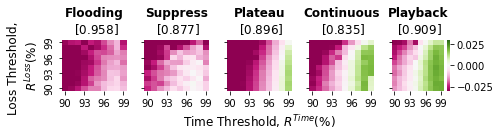

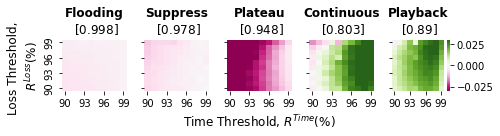

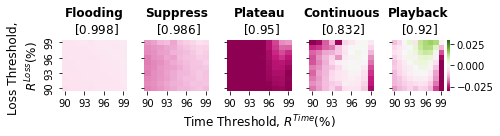

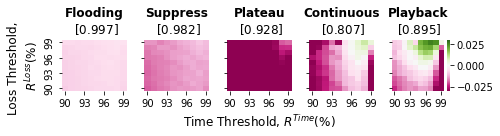

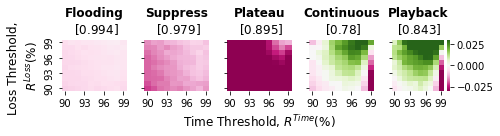

In [27]:
# sampling_period = 1
for sampling_period in sampling_periods:
    fig, axs = plt.subplots(1, len(testing_files), figsize = (7,2), sharex=True, sharey=True)
    for ax, file_name in zip(axs, testing_files):
        value = heatmap_auc_dict[f"{file_name}_{time_step}_{sampling_period}"][0].iloc[:-2,:-2][::-1]
        value.index = np.ceil(np.array(value.index)).astype(int)
        value.columns = np.ceil(np.array(value.columns)).astype(int)
        base = round(heatmap_auc_dict[f"{file_name}_{time_step}_{sampling_period}"][1],3)
        cbar = True if ax == axs[-1] else False
        sns.heatmap(value,  cmap="PiYG", vmin = -0.03, vmax = 0.03, square = False, cbar = cbar, xticklabels = 3, yticklabels = 3, ax = ax)
        ax.set_title(f"{file_name[:].capitalize()}\n $[{base}]$", weight='bold', fontsize = 12)

        
        if file_name == 'Flooding':
            ax.set_ylabel("Loss Threshold, \n$R^{{Loss}}(\%)$", fontsize = 12)
            # ax.set_yticks([90.0, 92.0, 94.0, 96.0, 98.0, 99.5])
            # ax.set_xticks(range(90, 100, 2))
        if file_name == 'Plateau':
            ax.set_xlabel("Time Threshold, $R^{Time}(\%)$", fontsize = 12)
    
    plt.tight_layout()
    plt.savefig(f"plots/{dataset}/improve-in-auc-tsp-analysis_{sampling_period}.jpg", dpi = 250)
    plt.savefig(f"plots/{dataset}/improve-in-auc-tsp-analysis_{sampling_period}.pdf")
    plt.show()

## Plot the impact of different sampling periods

In [28]:
if dataset == 'syncan':
    loss_factor = 95
    time_factor = 99
    time_step = 50

    prediction_df_final = pd.DataFrame([])

    for attack_name in tqdm(attacks_names):
                
        for sampling_period in sampling_periods:
            # print('sampling_period', sampling_period)

            heatmap_auc = pd.DataFrame([])
            
            prediction_df = pd.DataFrame([])
            y_pred_score = pd.DataFrame([])


            for file_name in attacks_dict[attack_name]:
                print(file_name)

                label_file_name = f"label_{file_name}_{time_step}_{sampling_period}_{file_size}"
                label_file_dir = f"data/label/{dataset}/{label_file_name}.csv"
                prediction_df = pd.concat([prediction_df, pd.read_csv(label_file_dir, index_col=False)], ignore_index=True)
        

                pred_file_name = f"prediction_{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}_{file_size}"
                pred_file_dir = f"data/prediction/{dataset}/{pred_file_name}.csv"
                # Starting with time steps violations.............
                y_pred_score = pd.concat([y_pred_score, pd.read_csv(pred_file_dir, index_col=False)], ignore_index=True)
                # y_pred_score = pd.read_csv(pred_file_dir, index_col=False)


            prediction_df = pd.concat([prediction_df, y_pred_score], ignore_index= False, axis = 1)
            prediction_df['Attack'] = attack_name
            prediction_df['Sampling Period'] = sampling_period
            
            print(prediction_df_final.shape, prediction_df.shape, sampling_period)

            prediction_df_final = pd.concat([prediction_df_final, prediction_df], ignore_index= False, axis = 0)
    prediction_df_final = prediction_df_final.rename(columns = {'0': "Loss"})


  0%|          | 0/5 [00:00<?, ?it/s]

test_flooding
(0, 0) (2570803, 5) 1
test_flooding
(2570803, 5) (2570803, 5) 5
test_flooding
(5141606, 5) (2570803, 5) 10
test_flooding
(7712409, 5) (2570803, 5) 20
test_flooding


 20%|██        | 1/5 [00:02<00:10,  2.66s/it]

(10283212, 5) (2570803, 5) 50
test_suppress
(12854015, 5) (2107647, 5) 1
test_suppress
(14961662, 5) (2107647, 5) 5
test_suppress
(17069309, 5) (2107647, 5) 10
test_suppress
(19176956, 5) (2107647, 5) 20
test_suppress
(21284603, 5) (2107647, 5) 50


 40%|████      | 2/5 [00:05<00:08,  2.95s/it]

test_plateau
(23392250, 5) (2145052, 5) 1
test_plateau
(25537302, 5) (2145052, 5) 5
test_plateau
(27682354, 5) (2145052, 5) 10
test_plateau
(29827406, 5) (2145052, 5) 20
test_plateau
(31972458, 5) (2145052, 5) 50


 60%|██████    | 3/5 [00:09<00:06,  3.42s/it]

test_continuous
(34117510, 5) (2145052, 5) 1
test_continuous
(36262562, 5) (2145052, 5) 5
test_continuous
(38407614, 5) (2145052, 5) 10
test_continuous
(40552666, 5) (2145052, 5) 20
test_continuous
(42697718, 5) (2145052, 5) 50


 80%|████████  | 4/5 [00:14<00:03,  3.95s/it]

test_playback
(44842770, 5) (2145052, 5) 1
test_playback
(46987822, 5) (2145052, 5) 5
test_playback
(49132874, 5) (2145052, 5) 10
test_playback
(51277926, 5) (2145052, 5) 20
test_playback
(53422978, 5) (2145052, 5) 50


100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


0it [00:00, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1it [00:10, 10.60s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2it [00:20, 10.47s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
3it [00:31, 10.36s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
4it [00:41, 10.33s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
5it [00:51, 10.37s/it]


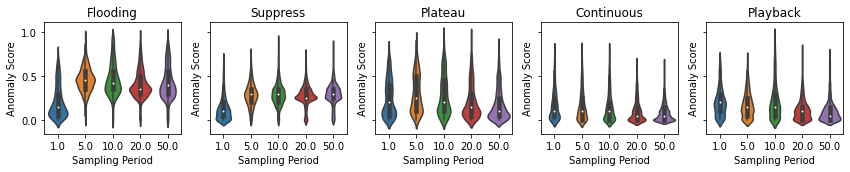

In [29]:
fig, axes = plt.subplots(1, 5, figsize = (12,2.5), sharey = True)
for ax, file_name in tqdm(zip(axes, testing_files)):
    filter1 = prediction_df_final["Attack"] == file_name
    filter2 = prediction_df_final["Label"] == 1
    prediction_df_final_cut = prediction_df_final.where(filter1 & filter2).dropna().sample(10000)

    sns.violinplot(x="Sampling Period", y="Loss",  data= prediction_df_final_cut, alpha = 0.5, ax = ax) #hue="Sampling Period",

    if ax != axes[-1]:
        ax.legend().set_visible(False)
    else:
        #ax.legend(title = 'Label', bbox_to_anchor = (1,1))
        ax.legend().set_visible(False)
    if ax != axes[0]:
        ax.set(ylabel=None)
    ax.set_title(f"{file_name.capitalize()}")
    ax.set_ylabel("Anomaly Score")
plt.tight_layout()
plt.savefig(f"plots/{dataset}/attack-wise-loss-for-diff-sp_vio.pdf")
plt.show()

0it [00:00, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1it [00:09,  9.86s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2it [00:19,  9.85s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
3it [00:29,  9.80s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
4it [00:39,  9.81s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
5it [00:49,  9.84s/it]


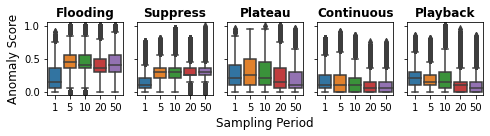

In [69]:
fig, axes = plt.subplots(1, 5, figsize = (7,2), sharey = True)
for ax, file_name in tqdm(zip(axes, testing_files)):
    filter1 = prediction_df_final["Attack"] == file_name
    filter2 = prediction_df_final["Label"] == 1
    prediction_df_final_cut = prediction_df_final.where(filter1 & filter2).dropna()
    prediction_df_final_cut['Sampling Period'] = prediction_df_final_cut['Sampling Period'].astype(int)


    # sns.barplot(x="Sampling Period", y="Loss", hue = 'Label', data= prediction_df_final_cut, ax = ax) #hue="Sampling Period",
    sns.boxplot(x="Sampling Period", y="Loss",  data= prediction_df_final_cut, ax = ax) #hue="Sampling Period", hue = 'Label',
    # sns.violinplot(x="Sampling Period", y="Loss",  data= prediction_df_final_cut, ax = ax) #hue="Sampling Period",

    ax.legend().set_visible(False)

    # adding transparency to colors
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # if ax != axes[-1]:
    #     ax.legend().set_visible(False)
    # else:
    #     ax.legend(title = 'Label', bbox_to_anchor = (1,1))
    # ax.grid(True)
    if ax != axes[0]:
        ax.set(ylabel=None)
    else:
        ax.set_ylabel("Anomaly Score", fontsize = 12)
    
    if ax != axes[2]:
        ax.set(xlabel=None)
    else:
        ax.set_xlabel("Sampling Period", fontsize = 12)

    ax.set_title(f"{file_name.capitalize()}", fontweight='bold', fontsize = 12) #    axs[file_index].set_title(f"{file_name} attack", fontweight='bold')
    
plt.tight_layout()
plt.savefig(f"plots/{dataset}/attack-wise-loss-for-diff-sp_box.pdf")
plt.savefig(f"plots/{dataset}/attack-wise-loss-for-diff-sp_box.jpg", dpi = 300)
plt.show()
#--------------------------------------------------------------------------

In [34]:

file_name_dict = {}
for file_name in testing_files:
    if dataset == 'road':
        file_name_dict[file_name] = file_name.capitalize()
    else:
        file_name_dict[file_name] = file_name.capitalize()
file_name_dict

{'Flooding': 'Flooding',
 'Suppress': 'Suppress',
 'Plateau': 'Plateau',
 'Continuous': 'Continuous',
 'Playback': 'Playback'}

In [35]:
base_df = prediction_df_final[prediction_df_final['Sampling Period'] == 1]
base_df['Model'] = "Mean-Absolute"


loss_avg = 0
for sampling_period in sampling_periods:
     loss_avg += prediction_df_final[prediction_df_final['Sampling Period'] == sampling_period][['Label', 'Loss']].values
loss_avg /= len(sampling_periods)
loss_avg

canshield_df = base_df.copy()
canshield_df['Label'] = (loss_avg[:,0]>0.50).astype(int)
canshield_df['Prediction'] = loss_avg[:,1]
canshield_df['Loss'] = loss_avg[:,1]
canshield_df['Model'] = "CANShield-Ensemble"
canshield_df

/tmp/ipykernel_1734013/929571273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df['Model'] = "Mean-Absolute"


,Label,Prediction,Loss,Attack,Sampling Period,Model
0,0,0.00,0.00,Flooding,1,CANShield-Ensemble
1,0,0.00,0.00,Flooding,1,CANShield-Ensemble
2,0,0.00,0.00,Flooding,1,CANShield-Ensemble
3,0,0.00,0.00,Flooding,1,CANShield-Ensemble
4,0,0.00,0.00,Flooding,1,CANShield-Ensemble
...,...,...,...,...,...,...
2145047,0,0.00,0.00,Playback,1,CANShield-Ensemble
2145048,0,0.00,0.00,Playback,1,CANShield-Ensemble
2145049,0,0.00,0.00,Playback,1,CANShield-Ensemble
2145050,0,0.01,0.01,Playback,1,CANShield-Ensemble


In [36]:
base_df

,Label,Prediction,Loss,Attack,Sampling Period,Model
0,0,0.010037,0.00,Flooding,1,Mean-Absolute
1,0,0.010793,0.00,Flooding,1,Mean-Absolute
2,0,0.009919,0.00,Flooding,1,Mean-Absolute
3,0,0.010414,0.00,Flooding,1,Mean-Absolute
4,0,0.010388,0.00,Flooding,1,Mean-Absolute
...,...,...,...,...,...,...
2145047,0,0.010576,0.00,Playback,1,Mean-Absolute
2145048,0,0.010557,0.00,Playback,1,Mean-Absolute
2145049,0,0.010434,0.00,Playback,1,Mean-Absolute
2145050,0,0.011546,0.00,Playback,1,Mean-Absolute


In [37]:
base_df = base_df.replace(file_name_dict)
label_list = np.array(['Benign', 'Attack'])
base_df["Label Name"] = label_list[base_df['Label']]
base_df['Prediction'] = base_df['Prediction']/base_df['Prediction'].max()

merged_df = pd.concat([base_df, canshield_df], ignore_index=True)


canshield_df = canshield_df.replace(file_name_dict)
label_list = np.array(['Benign', 'Attack'])
canshield_df["Label Name"] = label_list[canshield_df['Label']]
# canshield_df['Prediction'] = canshield_df['Prediction']/canshield_df['Prediction'].max()

In [38]:
canshield_df

,Label,Prediction,Loss,Attack,Sampling Period,Model,Label Name
0,0,0.00,0.00,Flooding,1,CANShield-Ensemble,Benign
1,0,0.00,0.00,Flooding,1,CANShield-Ensemble,Benign
2,0,0.00,0.00,Flooding,1,CANShield-Ensemble,Benign
3,0,0.00,0.00,Flooding,1,CANShield-Ensemble,Benign
4,0,0.00,0.00,Flooding,1,CANShield-Ensemble,Benign
...,...,...,...,...,...,...,...
2145047,0,0.00,0.00,Playback,1,CANShield-Ensemble,Benign
2145048,0,0.00,0.00,Playback,1,CANShield-Ensemble,Benign
2145049,0,0.00,0.00,Playback,1,CANShield-Ensemble,Benign
2145050,0,0.01,0.01,Playback,1,CANShield-Ensemble,Benign


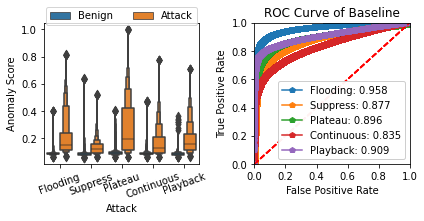

In [70]:
import sklearn.metrics as metrics
fig, axes = plt.subplots(1, 2, figsize = (6,3.25))
#-----------------------------------
ax = axes[0]
# sns.boxenplot(x="Attack", y="Prediction", hue = "Label Name", data=base_df , ax = ax) #.sample(100000)
sns.boxenplot(x="Attack", y="Prediction", hue = "Label Name", data=base_df , ax = ax) #.sample(100000)
ax.set_xticklabels(file_name_dict.values(), rotation = 20)
ax.legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.5, 1.15))
ax.set_ylabel("Anomaly Score")
#-----------------------------------
ax = axes[1]
baseline_autoencoder = {}

for file_name in file_name_dict.values():

    base_df_cut = base_df[base_df["Attack"] == file_name]
    fpr, tpr, threshold = metrics.roc_curve(base_df_cut['Label'], base_df_cut['Prediction'])
    roc_auc = metrics.auc(fpr, tpr)
    baseline_autoencoder[file_name] = roc_auc


    ax.plot(fpr, tpr, marker = 'p', label =f'{file_name}: {round(roc_auc,3)}')
    ax.set_title('ROC Curve of Baseline')
    ax.legend(loc = 'lower right', framealpha = 0.95)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
#-----------------------------------
plt.tight_layout()
# plt.savefig(f"plots/{dataset}/prediction-roc-baseline.pdf")
plt.savefig(f"plots/{dataset}/prediction-roc-baseline_{dataset}.jpg", dpi = 350)
plt.savefig(f"plots/{dataset}/prediction-roc-baseline_{dataset}.pdf", dpi = 200)

plt.show()


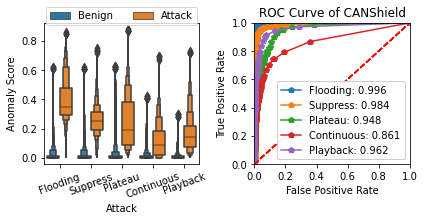

In [40]:
import sklearn.metrics as metrics
fig, axes = plt.subplots(1,2, figsize = (6,3.25))
#-----------------------------------
ax = axes[0]
sns.boxenplot(x="Attack", y="Prediction", hue = "Label Name", data=canshield_df, ax = ax) #.sample(100000)
# sns.boxplot(x="Attack", y="Prediction", hue = "Label Name", data=canshield_df, ax = ax) #.sample(100000)
ax.set_xticklabels(file_name_dict.values(), rotation = 20)
ax.legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0.5, 1.15))
ax.set_ylabel("Anomaly Score")

#-----------------------------------
ax = axes[1]
baseline_canshield = {}
for file_name in file_name_dict.values():

    base_df_cut = canshield_df[canshield_df["Attack"] == file_name]
    fpr, tpr, threshold = metrics.roc_curve(base_df_cut['Label'], base_df_cut['Prediction'])
    roc_auc = metrics.auc(fpr, tpr)
    baseline_canshield[file_name] = roc_auc
    ax.plot(fpr, tpr, marker = 'p', label =f'{file_name}: {round(roc_auc,3)}')
    ax.set_title('ROC Curve of CANShield')
    ax.legend(loc = 'lower right', framealpha = 0.95)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
# fig.suptitle("Mean absolute average Aproach")
plt.tight_layout()
# plt.savefig(f"plots/{dataset}/prediction-roc-canshield.pdf")
plt.savefig(f"plots/{dataset}/prediction-roc-canshield_{dataset}.jpg", dpi = 350)
plt.savefig(f"plots/{dataset}/prediction-roc-canshield_{dataset}.pdf", dpi = 200)
plt.show()

## Baseline Comparison -- Only on SynCAN

In [84]:
file_dict = {}
for file_name in testing_files:
    sig_fac ={}
    for sampling_period in sampling_periods:
        
        key = f"{file_name}_{time_step}_{sampling_period}"
        auc_score = heatmap_auc_dict[key][0].loc[loss_factor, time_factor] + heatmap_auc_dict[key][1]
        sig_fac[f"CANShield-{sampling_period}"] = auc_score
    file_dict[f"{file_name}"] = sig_fac

baseline_comparison_df = pd.DataFrame(file_dict)
baseline_comparison_df

,Flooding,Suppress,Plateau,Continuous,Playback
CANShield-1,0.939591,0.860359,0.907409,0.853096,0.927481
CANShield-5,0.996651,0.975657,0.944124,0.837021,0.905140
CANShield-10,0.994497,0.977641,0.923799,0.814178,0.888099
CANShield-20,0.989713,0.968512,0.894091,0.778702,0.845803
CANShield-50,0.989185,0.969369,0.859481,0.761540,0.823939


In [85]:
baseline_canshield

{'Flooding': 0.996121457044468,
 'Suppress': 0.9836685484269609,
 'Plateau': 0.9484981014340662,
 'Continuous': 0.8610997757754012,
 'Playback': 0.9619722599099981}

In [86]:
baseline_canshield_df = pd.DataFrame(pd.Series(baseline_canshield)).T
baseline_canshield_df.index = ['CANSheild-Ens']
baseline_canshield_df


,Flooding,Suppress,Plateau,Continuous,Playback
CANSheild-Ens,0.996121,0.983669,0.948498,0.8611,0.961972


In [87]:
baseline_autoencoder_df = pd.DataFrame(pd.Series(baseline_autoencoder)).T
baseline_autoencoder_df.index = ['CANShield-Base']
baseline_autoencoder_df

,Flooding,Suppress,Plateau,Continuous,Playback
CANShield-Base,0.958064,0.877097,0.896009,0.835113,0.909491


In [88]:
baseline_auc_df = pd.concat([baseline_autoencoder_df, baseline_comparison_df, baseline_canshield_df], ignore_index=False)

In [89]:
baseline_auc_df

,Flooding,Suppress,Plateau,Continuous,Playback
CANShield-Base,0.958064,0.877097,0.896009,0.835113,0.909491
CANShield-1,0.939591,0.860359,0.907409,0.853096,0.927481
CANShield-5,0.996651,0.975657,0.944124,0.837021,0.905140
CANShield-10,0.994497,0.977641,0.923799,0.814178,0.888099
CANShield-20,0.989713,0.968512,0.894091,0.778702,0.845803
CANShield-50,0.989185,0.969369,0.859481,0.761540,0.823939
CANSheild-Ens,0.996121,0.983669,0.948498,0.861100,0.961972


In [90]:

base_others = pd.DataFrame([], columns = ['Flooding' ,'Suppress', 'Plateau', 'Continuous', 'Playback'])
base_others.loc['CANet'] = [0.979 ,0.882, 0.983, 0.936, 0.974]
base_others.loc['Autoencoder'] = [0.755  ,0.563 ,0.530 ,0.874 ,0.489]   
base_others.loc['Predictive']   = [0.722 ,0.561 ,0.530, 0.874, 0.489]   
base_others

baseline_auc_final_df = np.round(pd.concat([baseline_auc_df, base_others],ignore_index = False),3)
baseline_auc_final_df.to_csv(f'data/results/{dataset}/baseline_auc_final_df.csv', header = True, index = True)

In [91]:
baseline_auc_final_df = baseline_auc_final_df.loc[['CANShield: 1', 'CANShield: 5', 'CANShield: 10',
       'CANShield: 20', 'CANShield: 50', 'CANSheild: Ens', 'CANShield: Base', 'CANet',
       'Autoencoder', 'Predictive']]

KeyError: "['CANShield: 1', 'CANShield: 5', 'CANShield: 10', 'CANShield: 20', 'CANShield: 50', 'CANSheild: Ens', 'CANShield: Base'] not in index"

In [ ]:
baseline_auc_df

,Flooding,Suppress,Plateau,Continuous,Playback
CANShield: Base,0.958064,0.877097,0.896009,0.835113,0.909491
CANShield: 1,0.939591,0.860359,0.907409,0.853096,0.927481
CANShield: 5,0.996651,0.975657,0.944124,0.837021,0.905140
CANShield: 10,0.994497,0.977641,0.923799,0.814178,0.888099
CANShield: 20,0.989713,0.968512,0.894091,0.778702,0.845803
CANShield: 50,0.989185,0.969369,0.859481,0.761540,0.823939
CANSheild: Ens,0.996121,0.983669,0.948498,0.861100,0.961972


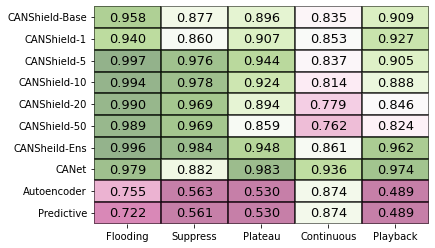

In [92]:
ax = sns.heatmap(baseline_auc_final_df, annot=True, fmt="0.3f", cmap="PiYG", alpha = 0.50,linewidths=0.05, linecolor='black', cbar=False, vmin = 0.70, vmax = 0.999, annot_kws={'fontsize': 13,  'color':'k', 'alpha': 0.99,
                       'rotation': 'horizontal', 'verticalalignment': 'center'}) #, 'fontstyle': 'italic',, 'backgroundcolor': 'w'}) #cmap="PiYG",


In [95]:
# for file_name in testing_files:
#     file_dict = {}
#     for signal_factor in signal_factors:
#         sig_fac ={}
#         key = f"{file_name}_{time_step}_{sampling_period}"
#         auc_score = heatmap_auc_dict[key][0].loc[loss_factor, time_factor]
#         sig_fac[f"CANShield: {signal_factor}"] = auc_score
#     file_dict[f"{file_name}"] = sig_fac

# baseline_comparison_df = pd.DataFrame(file_dict)
# baseline_comparison_df

## Ploting Precision, Recall, F1-Score

In [96]:
file_name = 'signal'
signal_th = pd.DataFrame([])
for sampling_period in sampling_periods:
    
    th_file_name = f"thresholds_{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
    th_file_dir = f"data/thresholds/{dataset}/{th_file_name}.csv"

    signal_th_sampling = pd.read_csv(th_file_dir, index_col=False)
    signal_th = pd.concat([signal_th, signal_th_sampling], ignore_index=True)

signal_th.groupby(['time_step','loss_factor','time_factor','signal_factor']).mean()
signal_th

,time_step,sampling_period,loss_factor,time_factor,signal_factor,th,Unnamed: 0
0,50,1,95.0,99.0,90.00,0.0000,NaN
1,50,1,95.0,99.0,91.00,0.0000,NaN
2,50,1,95.0,99.0,92.00,0.0250,NaN
3,50,1,95.0,99.0,93.00,0.0500,NaN
4,50,1,95.0,99.0,94.00,0.0500,NaN
...,...,...,...,...,...,...,...
57,50,50,95.0,99.0,97.00,0.1000,7.0
58,50,50,95.0,99.0,98.00,0.1000,8.0
59,50,50,95.0,99.0,99.00,0.1750,9.0
60,50,50,95.0,99.0,99.50,0.3000,10.0


In [97]:
signal_th = signal_th.fillna(0)

In [98]:
from sklearn.metrics import precision_recall_fscore_support


In [99]:
ths_list = np.array(range(0, 102, 2))/100
ths_list

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [100]:
prfs_df = []
for th in tqdm(ths_list):
    for file_name in canshield_df['Attack'].unique():
    # Calculating metrics
        canshield_df_cut = canshield_df[canshield_df['Attack'] == file_name]
        y_true = canshield_df_cut['Label']
        y_pred = (canshield_df_cut['Prediction']>th).astype(int)
        if y_pred.unique().shape[0] > 1:
            prfs_df.append(list(precision_recall_fscore_support(y_true, y_pred, average='binary')) + [file_name, th])
        else:
            if y_pred.unique()[0] == 0:
                # all zeros
                prfs_df.append([1.0, 0.0, 0.0, 0, file_name, th])
            else:
                # all ones
                prec = y_true.value_counts()[1]/(y_true.shape[0])
                f1_score  = 2*prec*1.0/(prec+1.0)
                prfs_df.append([prec, 1.0, f1_score, 0, file_name, th])        

100%|██████████| 51/51 [03:45<00:00,  4.42s/it]


In [101]:
prfs_df = pd.DataFrame(prfs_df, columns = ['Precision', 'Recall', 'F1 Score', 'Support', 'Attack', 'Signal Threshold'])
prfs_df.head()

,Precision,Recall,F1 Score,Support,Attack,Signal Threshold
0,0.576927,0.998892,0.731413,NaN,Flooding,0.0
1,0.410189,0.991401,0.580286,NaN,Suppress,0.0
2,0.375281,0.986888,0.543781,NaN,Plateau,0.0
3,0.308918,0.867732,0.455629,NaN,Continuous,0.0
4,0.380565,0.972259,0.547015,NaN,Playback,0.0


In [102]:
signal_factors_ticks = np.array(signal_factors, dtype = 'str')

In [103]:
auc_pr = {}
for attack in attacks_names:
    prfs_df_attack = prfs_df[prfs_df['Attack'] == attack]
    auc_pr[attack] = np.round(metrics.auc(prfs_df_attack['Recall'], prfs_df_attack['Precision']),3)
    print(attack, auc_pr[attack])

Flooding 0.991
Suppress 0.927
Plateau 0.824
Continuous 0.658
Playback 0.88


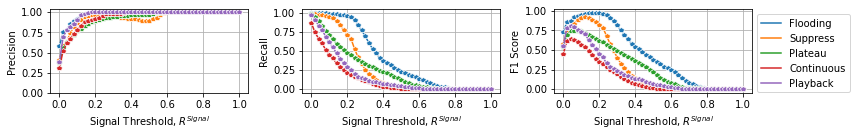

In [104]:
#--------------------------------------------------------------------------
fig, axes = plt.subplots(1,3, figsize = (12,2))
metrics_list = ['Precision', 'Recall', 'F1 Score']

for ax, metric in zip(axes, metrics_list):
    sns.lineplot(x="Signal Threshold", y= metric, hue = 'Attack', marker = 'p', data=prfs_df, ax = ax)
    ax.grid(True)
    if ax == axes [-1]:
        ax.legend(bbox_to_anchor = (1,1))
        # ax.legend().set_visible(False)
        # fig.legend(ncol = 5, bbox_to_anchor = (0.5,1.02), loc = 'upper center', framealpha = 0.10) #pass
    else:
        ax.legend().set_visible(False)
    ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.00])
    ax.set_xlabel("Signal Threshold, $R^{Signal}$")
    # ax.set_xlabel("Signal Threshold, $R^{Signal}$")

# fig.legend(ncol = 5, bbox_to_anchor = (0.5,1.25), loc = 'upper center')
# fig.suptitle("Window-wise Precision-Recall-F1 Scores on SynCAN Dataset for Different Signal Thresholds")
# fig.text(0.185,1.125, "Window-wise Precision-Recall-F1 Scores on SynCAN Dataset for Different Signal Thresholds")
plt.tight_layout()
# plt.savefig(f"plots/{dataset}/pre-rec-f1-canshield.jpg", dpi = 400)
plt.savefig(f"plots/{dataset}/pre-rec-f1-canshield_{dataset}.pdf")
plt.show()
#--------------------------------------------------------------------------

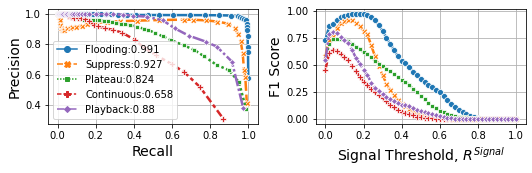

In [105]:
#--------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize = (7.5,2.5))
ax = axes[0]
sns.lineplot(y ="Precision", x = "Recall", hue = 'Attack', style = 'Attack', markers = True, linewidth = 2.5, data=prfs_df, ax = ax)
ax.legend(loc = 'lower left')
ax.set_ylabel("Precision", fontsize = '14')
ax.set_xlabel("Recall", fontsize = '14')
ax.grid(True)


# check axes and find which is have legend
leg = ax.get_legend()
# new_title = 'My title'
# leg.set_title(new_title)
# new_labels = [attack_short_dict[attack] + f" :{auc_pr[attack]}" for attack in attacks_names]
new_labels = [attack + f":{auc_pr[attack]}" for attack in attacks_names]

for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
#----------------------------


ax = axes[1]
sns.lineplot(x="Signal Threshold", y= "F1 Score", hue = 'Attack', style = 'Attack', markers = True, linewidth = 2.5, data=prfs_df, ax = ax)
ax.legend().set_visible(False)
ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.00])
ax.set_xlabel("Signal Threshold, $R^{Signal}$", fontsize = '14')
ax.set_ylabel("F1 Score", fontsize = '14')
ax.grid(True)


# fig.text(0.185,1.125, "Window-wise Precision-Recall-F1 Scores on SynCAN Dataset for Different Signal Thresholds")
plt.tight_layout()
# plt.savefig(f"plots/{dataset}/pre-rec-f1-canshield.jpg", dpi = 400)
plt.savefig(f"plots/{dataset}/pre-rec_curve-w-f1-canshield_{dataset}.pdf")
plt.show()
#--------------------------------------------------------------------------

In [106]:
file_name_dict
t_mgs = 2

0 Flooding
1:  [[5822, 12093, 6271], [22985, 30175, 7190], [42157, 48212, 6055], [64426, 73009, 8583], [83176, 88730, 5554], [101286, 106312, 5026], [116300, 120377, 4077], [136796, 143395, 6599], [157703, 165956, 8253], [179611, 185063, 5452], [198576, 206558, 7982], [223384, 227694, 4310], [246824, 250910, 4086], [262365, 269471, 7106], [281311, 286938, 5627], [304006, 311263, 7257], [326970, 333510, 6540], [344239, 350845, 6606], [367130, 373773, 6643], [391740, 398524, 6784], [414503, 422326, 7823], [432985, 437786, 4801], [454774, 462626, 7852], [482289, 491742, 9453], [511497, 522714, 11217], [537189, 542858, 5669], [554525, 559503, 4978], [573143, 581123, 7980], [600406, 610852, 10446], [623585, 628749, 5164], [646943, 653112, 6169], [665242, 670744, 5502], [689673, 697855, 8182], [711488, 722373, 10885], [741058, 748048, 6990], [763103, 770847, 7744], [781805, 789125, 7320], [808888, 814361, 5473], [831666, 836006, 4340], [848000, 857456, 9456], [870178, 875358, 5180], [888447,

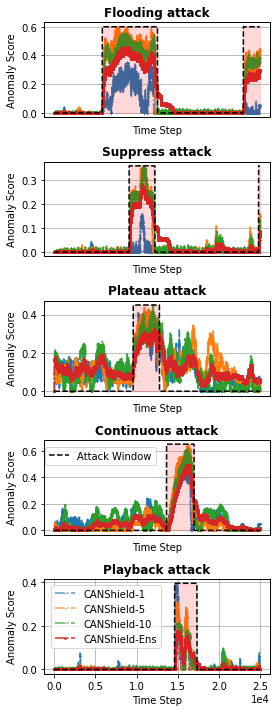

In [107]:
# Only Graphs..............
latency_df = []
event_df = []
# fpr_list = [0.001, 0.005, 0.01]
fpr_list = [0.001, 0.005, 0.01] #, 0.05]
# fpr_list = [0.005]
sampling_periods_opt = [1, 5, 10]
roll_window = 10

t_mgs = 1 if dataset == 'syncan' else 1

#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
fig, axs = plt.subplots(5, 1, figsize = (4, 10), gridspec_kw={'width_ratios': [1.85]})

# Starting with attack names...............
for file_index,  file_name in enumerate(testing_files):

    # if file_index < 3: 
    #     continue
    ax2 = axs[file_index].twinx()
    print(file_index, file_name)

    best_auc = 0
    x = 0
    y = 25000 if dataset == 'syncan' else  -1

    #--------------------------------------------
    prediction_df_attack = prediction_df_final[prediction_df_final["Attack"] == file_name] #.sample(10000)
    # canshield_df_attack = canshield_df[canshield_df["Attack"] == file_name[5:].capitalize()] #.sample(10000)
    canshield_df_attack = canshield_df[canshield_df["Attack"] == file_name] #.sample(10000)

    for sampling_period_indx, sampling_period in enumerate(sampling_periods_opt):
        prediction_df_attack_samp = prediction_df_attack[prediction_df_attack["Sampling Period"] == sampling_period] #.sample(10000)
        # canshield_df_attack_samp = canshield_df_attack[canshield_df_attack["Sampling Period"] == sampling_period] #.sample(10000)

        #------------------------------
        y_pred = prediction_df_attack_samp["Loss"].rolling(roll_window).mean().fillna(0).values
        y_test = prediction_df_attack_samp["Label"].values


        # Interpolating small discontinuity...
        if file_name == 'Max engine coolant temp':
            attacks, attack_index = find_attacks(y_test)
            attack_start = attacks[0][0]
            for [start, end, dur] in attacks:
                
                if end == attacks[-1][1]:
                    y_test[attack_start: end] = 1

                elif dur <= 10:
                    attack_end = end
                    continue
                else:
                    y_test[attack_start: end] = 1
                    attack_start = start
        #-------------------------------------


        # plot line graph...........
        axs[file_index].plot(y_pred[x:x+y], label=f"CANShield-{sampling_period}", alpha = 0.75,  linestyle = '-.', marker = 'p', markersize = '0.5')

        fpr, tpr, ths = roc_curve(y_test, y_pred)
        roc_auc = metrics.auc(fpr, tpr)              
        # axs[file_index, 1].plot(fpr, tpr, label=f"{sampling_period}: {round(roc_auc, 3)}", marker = 'p')

        # Determining delays........
        attacks, attack_index = find_attacks(y_test)
        print(f"{sampling_period}: ", attacks)
        #------------------------------
        # print(attacks)
        for fpr_th in fpr_list:
            th = ths[fpr > fpr_th][0]
            
            tpr_opt = tpr[fpr <= fpr_th][-1]
            y_pred_bin = (y_pred > th).astype(int).copy()
            
            #------------------------------------
            for attack in attacks:
                try:
                    delay = np.where(y_pred_bin[attack[0]:attack[1]] == 1)[0][0]
                    print(f"{file_name}: {sampling_period}: {fpr_th} : {attack[0]}", delay)
                    # if delay < 1000:
                    # latency_df.append([file_name, str(sampling_period), fpr_th, tpr_opt, delay*t_mgs])
                except:
                    delay = attack[2]
                    #latency_df.append([file_name, str(sampling_period), fpr_th, tpr_opt, delay])
                
                latency_df.append([file_name, str(sampling_period), fpr_th, tpr_opt, delay*t_mgs])

            #------------------------------------
        
            # #-------- Defining event detection rate----
            # for detection_q in range(0,100,50):
            #     attack_count = 0
            #     for [attack_init, attack_end, attack_len]  in attacks:
            #         if y_pred_bin[attack_init: attack_end].sum() >= attack_len*detection_q/100:
            #             attack_count += 1
            #     event_detection = attack_count/len(attacks)*100
            #     event_df.append([file_name, sampling_period, fpr_th, detection_q, event_detection])
            # #------------------------------------
    # TODO Fix code here....
    # Starting with ensemble scenario......................................................................
        
    y_pred_avg = canshield_df_attack['Prediction'].rolling(roll_window).mean().fillna(0).values.copy()
    # y_test_avg = canshield_df_attack['Label'].rolling(50).mean().fillna(0).copy()
    # y_test_avg = canshield_df_attack['Label'].rolling(50).mean().fillna(0).copy()
    # y_test_avg[y_test_avg>0] = 1

    y_test_avg = canshield_df_attack['Label'].copy()

    # Interpolating small discontinuity...
    if file_name == 'Max engine coolant temp':
        attacks, attack_index = find_attacks(y_test_avg)
        attack_start = attacks[0][0]
        for [start, end, dur] in attacks:
            
            if end == attacks[-1][1]:
                y_test_avg[attack_start: end] = 1

            elif dur <= 10:
                attack_end = end
                continue
            else:
                y_test_avg[attack_start: end] = 1
                attack_start = start
    #-------------------------------------

    # y_test_avg[y_test_avg < 1] = 0
        
            
    ax2.plot(y_test_avg[x:x+y], label=f"Attack Window", color= 'k', linestyle = '--')#, marker = 'p')
    #TODO: fill issues...
    # ax2.fill_between(range(y),y_test_avg[x:x+y], alpha = 0.15, color = 'r')
    ax2.fill_between(range(y_test_avg[x:x+y].shape[0]),y_test_avg[x:x+y], alpha = 0.15, color = 'r')

    ax2.set_yticks([])
    axs[file_index].plot(y_pred_avg[x:x+y], label=f"CANShield-Ens", linestyle = '-.', marker = 'p', markersize = '2')
    axs[file_index].set_xlabel("Time Step")
    axs[file_index].set_ylabel("Anomaly Score")
    ax2.set_yticks([])

    # ax2.set_ylabel("G. Truth")
#             axs[file_index, 0].set_title(f"Attack: {file_details[file_name]}")
    axs[file_index].set_title(f"{file_name} attack", fontweight='bold')
    # axs[file_index, 0].set_title(f"Anomaly scores for {file_name.lower()} attack")
    # axs[file_index, 1].set_title(f"ROC Curve & AUC Score")

    fpr, tpr, ths = roc_curve(y_test_avg, y_pred_avg)
    roc_auc = metrics.auc(fpr, tpr)
    
    # axs[file_index, 1].plot(fpr, tpr, label=f"Ens. : {round(roc_auc, 3)}", marker = 'p')
    # axs[file_index, 1].set_xlabel("False Positive Rate")
    # axs[file_index, 1].set_ylabel("True Positive Rate")
    # axs[file_index, 1].legend() #, loc = 'center right')
    
    # Determining delays........
    attacks, attack_index = find_attacks(y_test_avg)
    print("Average: ", attacks)
    # print(attacks)
    for fpr_th in fpr_list:
        th = ths[fpr >= fpr_th][0]
        tpr_opt = tpr[fpr <= fpr_th][-1]
        
        y_pred_avg_bin = (y_pred_avg >= th).astype(int).copy()

        for attack in attacks:
        #------- Defining latency--------------
            try:
                delay = np.where(y_pred_avg_bin[attack[0]:attack[1]] == 1)[0][0]
                print(f"{file_name}: Ens: {attack}", delay)
                # if delay < 1000:
                # latency_df.append([file_name, "Ens.", fpr_th, tpr_opt, delay*t_mgs])
                # else:
                #     print(delay)
            except:
                delay = attack[2]
                #latency_df.append([file_name, "Ens.", fpr_th, tpr_opt, delay*t_mgs])
            
            latency_df.append([file_name, "Ens.", fpr_th, tpr_opt, delay*t_mgs])

            
        #------------------------------------
            
        # #-------- Defining event detection rate----
        # for detection_q in range(0,100,50):
        #     attack_count = 0
        #     for [attack_init, attack_end, attack_len]  in attacks:
        #         if y_pred_avg_bin[attack_init: attack_end].sum() >= attack_len*detection_q/100:
        #             attack_count += 1
        #     event_detection = attack_count/len(attacks)*100
        #     event_df.append([file_name, "Ens.", fpr_th, detection_q, event_detection])
        # #------------------------------------
        if file_index == 3:
            # axs[file_index, 0].legend(ncol = 1, bbox_to_anchor=(0.275, 0.99), loc='upper center')
            ax2.legend(bbox_to_anchor=(0.25, 0.98), loc='upper center') #, ncol = 4)

        if file_index == 4:
            axs[file_index].legend(ncol = 1, bbox_to_anchor=(0.275, 0.99), loc='upper center')
            #ax2.legend(bbox_to_anchor=(0.225, 0.50), loc='upper center') #, ncol = 4)
        if file_index != 4:
            axs[file_index].set_xticks([])
            # axs[file_index, 1].set_xticks([])
        
        axs[file_index].grid(True)
        #axs[file_index, 1].grid(True)
        ax2.grid(True)

    #ax.legend()
#     ax.ticklabel_format(useOffset=False, style='sci')

ax2.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))

plt.tight_layout()
# plt.savefig(f"plots/{dataset}/attack_vis_only_{dataset}.jpg", dpi = 250)
# plt.savefig(f"plots/{dataset}/attack_vis_only_{dataset}.pdf", dpi = 250)
# plt.savefig(f"plots//final//attack_vis_only_{dataset}.jpg", dpi = 450)
# plt.savefig(f"plots//final//attack_vis_only_{dataset}.pdf")
plt.show()  

## Plotting Latency Curve ...

In [108]:
if dataset == 'syncan':
    attack_short_dict = {}
    for attack in attacks_names:
        attack_short_dict[attack] = attack
attack_short_dict

{'Flooding': 'Flooding',
 'Suppress': 'Suppress',
 'Plateau': 'Plateau',
 'Continuous': 'Continuous',
 'Playback': 'Playback'}

In [109]:
latency_df = pd.DataFrame(latency_df)
latency_df.columns = ['Attack', 'Sampling Period(s)', 'Max FPR', 'True Positive Rate', 'Detection Latency']

latency_df_avg = latency_df.groupby(['Sampling Period(s)', 'Max FPR']).mean().copy()
latency_df_avg[['Attack','Sampling Period(s)', 'Max FPR']] = [["Average"] + list(x) for x in latency_df_avg.index]
latency_df_new = pd.concat([latency_df, latency_df_avg], ignore_index = True)
latency_df_new


latency_df_new['Detection Latency'] = latency_df_new['Detection Latency']*2 / 1000
latency_df_new['Max FPR'] = latency_df_new['Max FPR'] * 100

Flooding
Suppress
Plateau
Continuous
Playback


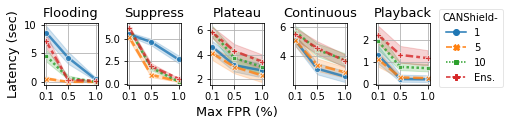

In [110]:
hue_order = ['1', '5', '10', 'Ens.']


fig, axs = plt.subplots(1,5, figsize = (7.5,1.85), sharey = False)
for file_name, ax in zip(testing_files[0:], axs.flatten()):

    print(file_name)
    latency_df_clean = latency_df_new[latency_df_new['Attack'] == file_name]
    
    # sns.barplot(data = latency_df_clean, alpha = .80, hue_order = hue_order, x="Max FPR", y="Detection Latency", hue='Sampling Period(s)', ax = ax)
    sns.lineplot(data = latency_df_clean, alpha = .80,  x="Max FPR", y="Detection Latency", hue='Sampling Period(s)',style='Sampling Period(s)', markers = True, linewidth = 2.5, ax = ax)
    ax.set_title(attack_short_dict[file_name].capitalize(), fontsize = '13')
    ax.grid(True)
    
    if ax == axs[0]:
        #ax.legend(title = '$T_x$', framealpha = 0.25, ncol = 1, loc = 'center', bbox_to_anchor = (0.75, 0.475))
#         ax.legend(title = '$T_x$', framealpha = 0.5, ncol = 1, loc = 'best') #, bbox_to_anchor = (0.75, 0.475))
        # ax.set_ylabel('Latency (sec)', fontsize = '13')
        if dataset == 'road':
            ax.set_ylabel('Latency (ms)', fontsize = '13')
        else:
            ax.set_ylabel('Latency (sec)', fontsize = '13')            
    else:
#         ax.legend([])
        ax.set_ylabel(None)   
    
    if ax == axs[-1]:
        ax.legend(title = 'CANShield-', framealpha = 0.49, ncol = 1, loc = 'center', bbox_to_anchor = (1.75, 0.60))

    else:
        ax.legend('', frameon=False)
    
    ax.set_xticks([0.1, 0.5, 1.0])

    # ax.set_xlabel("Max FPR", fontsize = '13')
    if ax == axs[2]:
        ax.set_xlabel("Max FPR (%)", fontsize = '13')
    else:
        ax.set_xlabel(None)

    
plt.tight_layout()
plt.savefig(f"plots/{dataset}/detection_latency_{dataset}.pdf", dpi = 250)
plt.savefig(f"plots/{dataset}/detection_latency_{dataset}.pdf", dpi = 250)
plt.show()  

In [111]:
df_model_opt = pd.read_csv("plots/syncan/plot-data-syncan.csv")
df_model_opt

,No of AE(s),Max F1 Score,View Length (w)
0,1,0.91185,100
1,2,0.93431,100
2,3,0.94240,100
3,4,0.93787,100
4,5,0.92418,100
5,1,0.92418,25
6,2,0.94390,25
7,3,0.94924,25
8,4,0.94911,25
9,5,0.94856,25


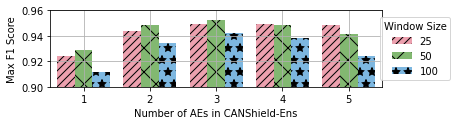

In [112]:
import seaborn as sns
from itertools import cycle

# Try playing with one set or another:
plt.figure(figsize=(6.5,1.85))
palette = sns.color_palette("husl", 3)
ax = sns.barplot(data = df_model_opt, x = "No of AE(s)", y = "Max F1 Score", hue = "View Length (w)",  palette = palette, alpha = 0.75)
ax.set(ylim=[0.9, 0.96])
# Define some hatches
hatches = cycle(['///', 'x', '*'])

num_locations = len(df_model_opt["No of AE(s)"].unique())
for i, patch in enumerate(ax.patches):
    # Blue bars first, then green bars
    if i % num_locations == 0:
        hatch = next(hatches)
    patch.set_hatch(hatch)

ax.legend(title = "Window Size", loc='center', bbox_to_anchor = (1.1, 0.5))
ax.set_xlabel("Number of AEs in CANShield-Ens")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"plots/{dataset}/Average_AUC_Scores_Final_syncan-v2.pdf")
plt.show()

# The End